# What permutation tests to do?

I need to work out what permutation tests to do. There are several ways we can compare X:A or Y:A or 4:A. 

These data are challenging because at the individual gene cell level the data are very sparse. One solution to this problem is to aggregate data to the cell type level. Unfortunately, the missingness is not completely random and shows distinct patterns for different cell types. Making me worry that aggregating to the cell type level would incorporate bias differently for each cell type. To combat this problem we are taking a permutation approach, where we can randomly sample cells and calculate a statistic that should help us capture trends inspite of the missingness. 

For looking at X:A expression, I need to decide what measure to use along with what statistic. 

## Possible Measures

There are a number of ways to look at X:A. Here are a few possible measures that we could use.

* Compare read counts per chromosome normalized by chromosome length. (It may be hard to get chromosome counts per cell)
* Compare read counts mapped to genic regions normalized by gene count (or total gene length).
* Compare the proportion of genes "expressed".
* Compare read count mapping to specific genes (i.e., housekeeping genes).

The X chromosome is rather comparable in size and gene content to 2L, 2R, 3L, and 3R. I think the first three measures should all behave similarly. However, ultimately we also want to look at the behavior of Y and 4th in relation to the autosomes. These chromosomes have large differences in size and gene content, so I don't know if that will affect the usefullness of these three measures. 

The last measure conceptually sounds nice, housekeeping genes are throught to behave similarly across cell types. Any change is housekeeping expression would give strong evidence. However, annotation of what is a "housekeeping" gene is challenging, and more importantly these genes are not likely to be equally distributed across chromosomes. 

In [5]:
import os
import sys
import re
from pathlib import Path
from collections import defaultdict
from itertools import combinations

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, ks_2samp, friedmanchisquare, kruskal
from statsmodels.stats.multitest import multipletests

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import commonly_expressed
from larval_gonad.stats import permutation_sample, permuted_replicates, enrichment_statistic

In [6]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-01-09 
Git hash: 0d55d559f15e72997fbb0400da4a764793255e88


In [176]:
def plot(rep):
    chrom_counts = pd.read_csv(f'../output/scrnaseq-wf/scrnaseq_samples/testis{rep}_force/outs/possorted_genome_bam.bam_counts', sep='\t', index_col=0)
    chrom_counts.index = pd.Index([f'rep{rep}_' + x for x in chrom_counts.index], name='cell_id')
    chrom_counts = chrom_counts[chrom_counts.index.isin(clusters.index)].copy()
    chrom_counts.chromosome = [f'chr{x}' for x in chrom_counts.chromosome]
    totals = chrom_counts.groupby('cell_id').number_reads.sum()
    totals.name = 'totals'
    chrom_counts = chrom_counts.join(totals)
    chrom_counts['scaled_reads'] = chrom_counts.number_reads / (chrom_counts.totals / 1e3)

    chrom_sizes = pd.read_csv('/data/LCDB/lcdb-references/dmel/r6-16/fasta/dmel_r6-16.chromsizes', sep='\t', index_col=0, header=None)
    chrom_sizes.index.name = 'chrom'
    chrom_sizes.columns = ['chrom_length']

    chrom_counts = chrom_counts.reset_index().merge(chrom_sizes, left_on='chromosome', right_on='chrom', how='left').set_index('cell_id')
    chrom_counts['normalized_reads'] = chrom_counts.scaled_reads / (chrom_counts.chrom_length / 1e6)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
    for ax, (cell_type, dd) in zip(axes.flat, chrom_counts.join(clusters, how='left').groupby('cluster')):
        for chrom, ddd in dd.groupby('chromosome'):
            sns.kdeplot(np.log10(ddd.normalized_reads), label=chrom, ax=ax, legend=False)
        ax.set_title(cell_type)
    axes[0, -1].legend(loc='center left', bbox_to_anchor=[1, 0.5])
    fig.suptitle(f'rep{rep}')

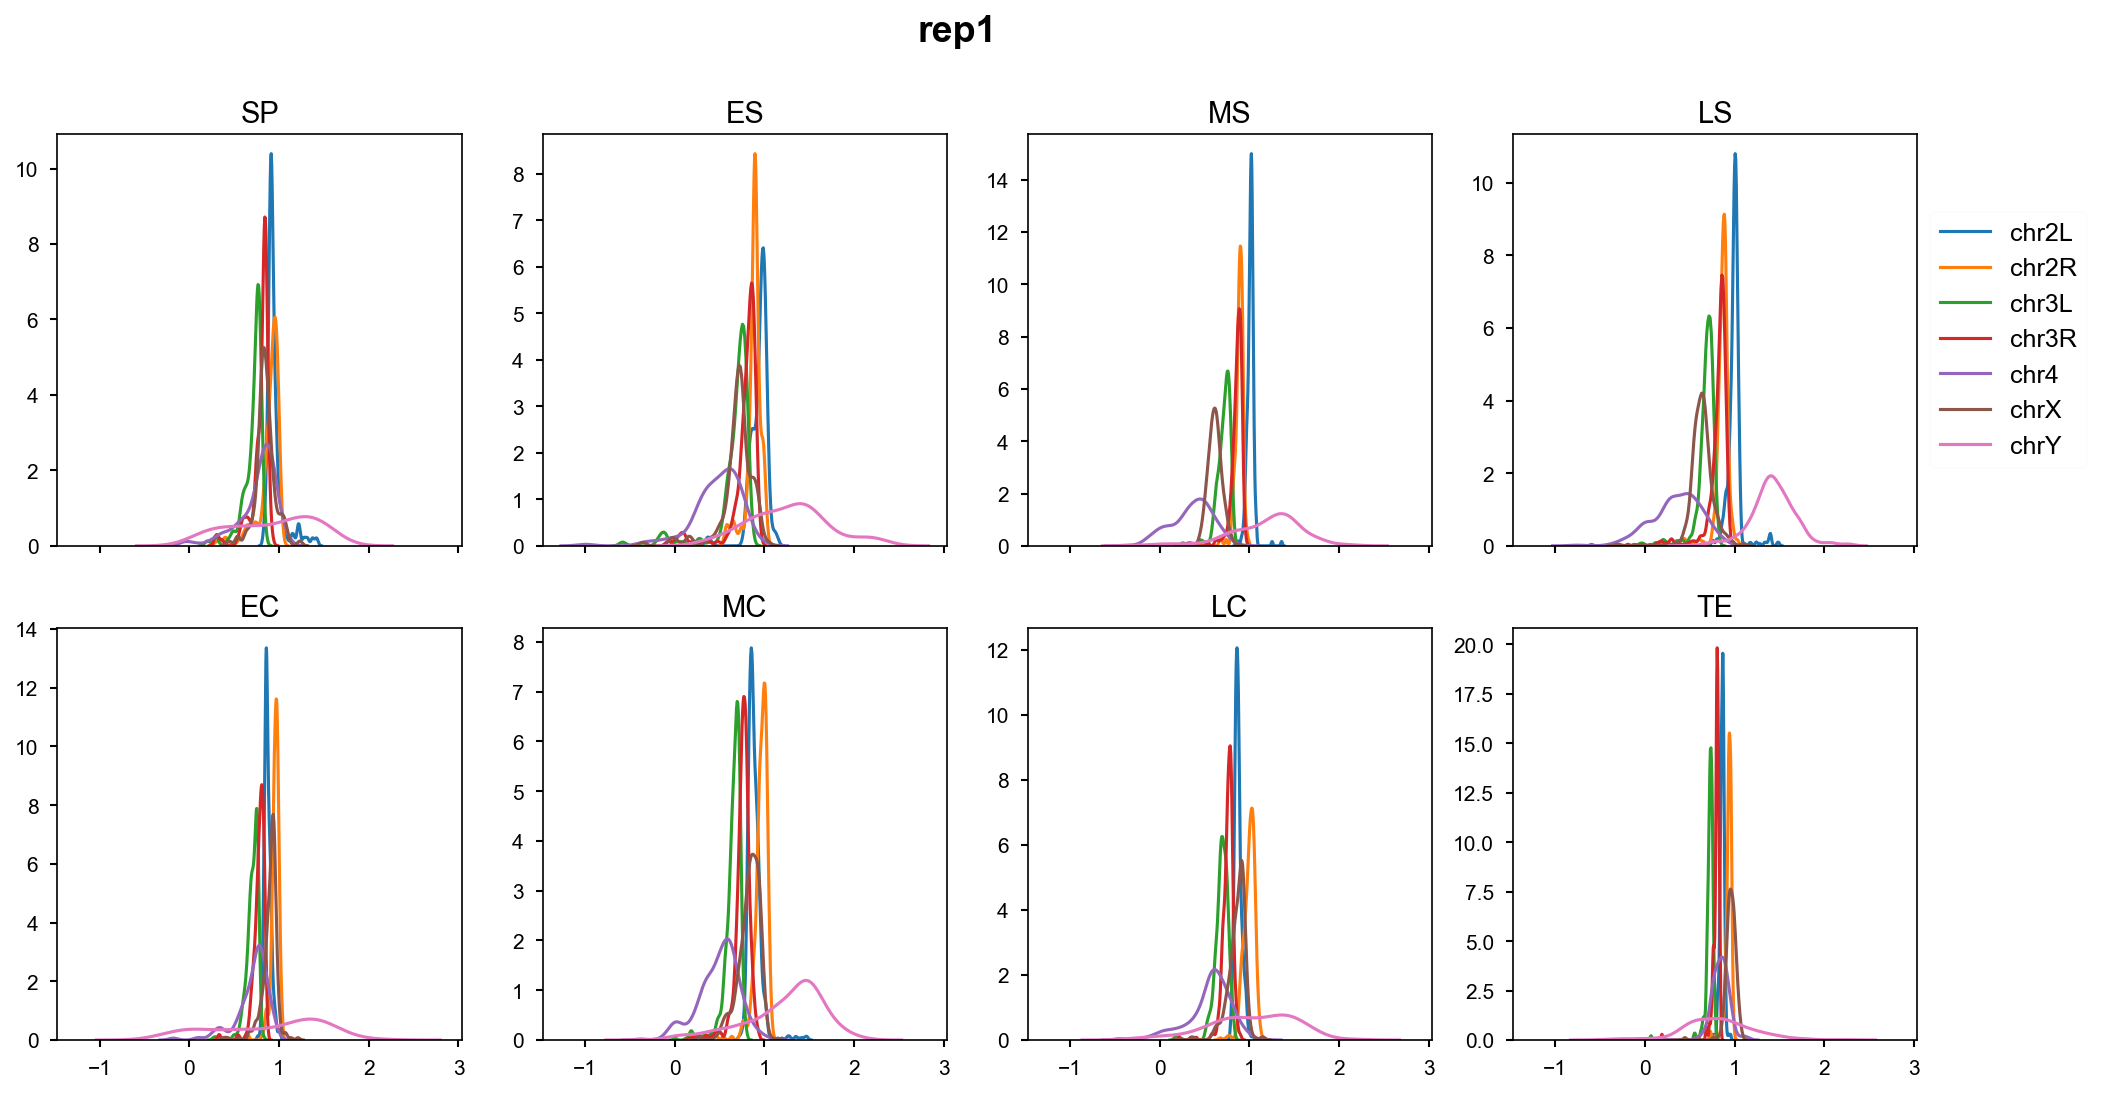

In [177]:
plot(1)

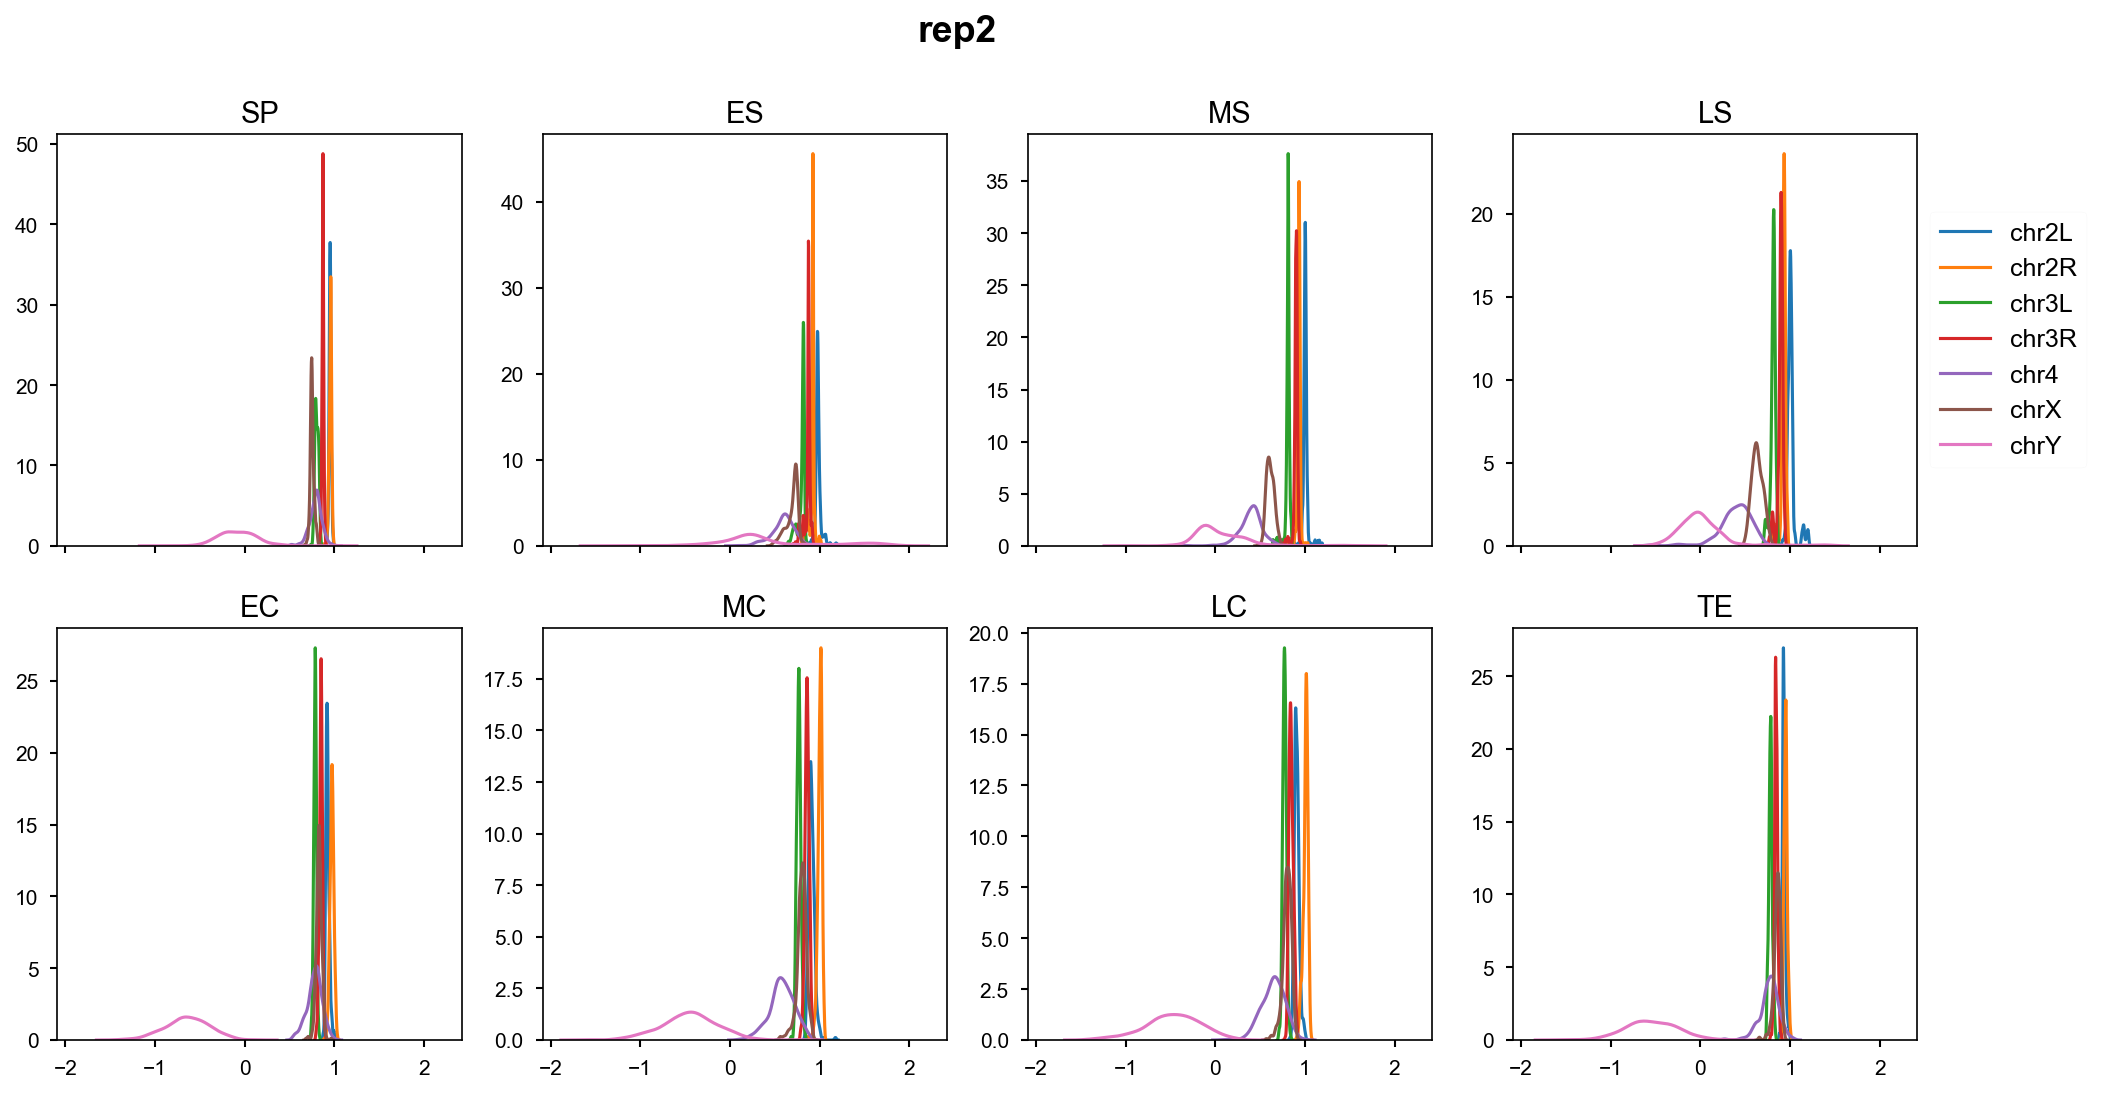

In [178]:
plot(2)

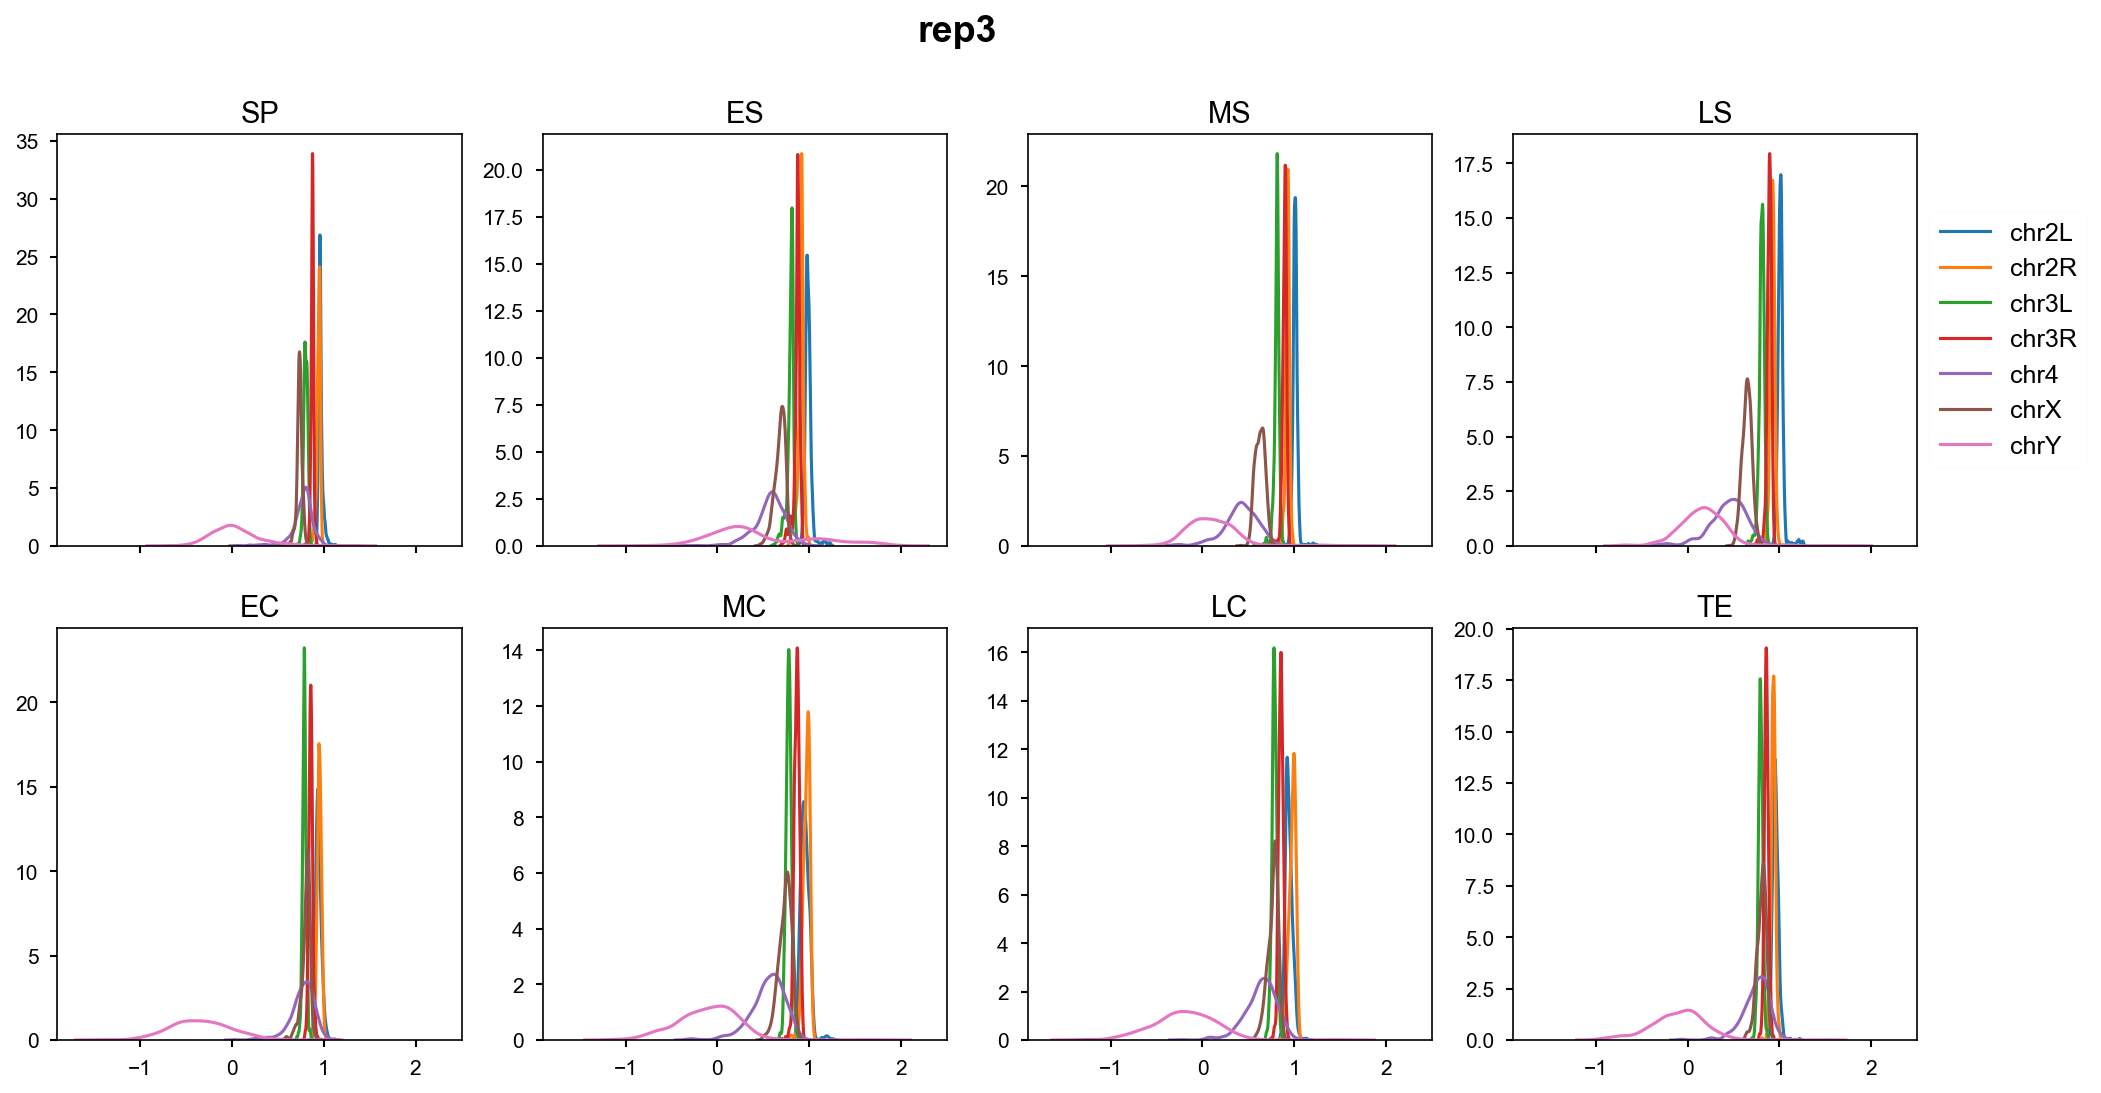

In [179]:
plot(3)

In [4]:
# Get clusters and rename using abbreviation.
cluster_annot = {
    0: 'LS',
    1: 'MC',
    2: 'MS',
    3: 'ES',
    4: 'LC',
    5: 'EC',
    6: 'SP',
    7: 'TE',
    8: 'PC',
}

cluster_order = [
    'SP',
    'ES',
    'MS',
    'LS',
    'EC',
    'MC',
    'LC',
    'TE',
    'PC',
]

clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters[(clusters != 9) & (clusters != 10) & (clusters != 11)].copy()
clusters = clusters.map(cluster_annot)
clusters = pd.Series(pd.Categorical(clusters.values, categories=cluster_order, ordered=True), index=pd.Index(clusters.index, name='cell_id'), name='cluster').to_frame()
clusters['rep'] = clusters.index.str.extract('(rep\d)_').values.flatten()

In [4]:
# 
chroms = nbconfig.fbgn2chrom.query('chrom != "chrY" & chrom != "chrM" & chrom != "chr4"').copy()
chroms.chrom = chroms.chrom.astype('category')
chroms.chrom = chroms.chrom.cat.reorder_categories(nbconfig.chrom_order[:-2])

In [5]:
autosomes = ['chr2L', 'chr2R', 'chr3L', 'chr3R']

In [6]:
xa = chroms.copy()
xa.chrom = xa.chrom.astype(str)
xa.loc[xa.chrom.isin(autosomes), 'chrom'] = 'A'
xa.loc[xa.chrom == 'chrX', 'chrom'] = 'X'
xa = xa.chrom.astype('category')
xa = xa.cat.reorder_categories(['X', 'A'])
xa = xa.cat.as_ordered()

In [7]:
norm = nbconfig.seurat.get_normalized_read_counts()

In [8]:
norm = norm.reindex(commonly_expressed(data=norm))

In [9]:
def prop_on(x):
    return x.sum() / x.shape[0]

In [10]:
def _run1(cluster, rep, dat):
    prop_genes_on = (dat > 0).join(chroms).groupby('chrom').agg(prop_on).T
    
    
    # Permutation test for each pairwise chromosome get stats
    pvals = list()
    cbn = list(combinations(prop_genes_on.columns, 2))
    for c1, c2 in cbn:
        _d1 = prop_genes_on[c1]
        _d2 = prop_genes_on[c2]
        
        obs = statistic(_d1, _d2)
        perms = draw_perm_reps(_d1, _d2, func=statistic, size=1_000)
        pval = np.sum(perms >= obs) / len(perms)
        pvals.append((c1, c2, pval))
    
    return pvals


results = []
for (clus, rep), dd in clusters.groupby(['cluster', 'rep']):
    _dat = norm.reindex(columns=dd.index)
    for res in _run1(clus, rep, _dat):
        results.append([clus, rep, *res])

df = pd.DataFrame(results, columns=['cluster', 'rep', 'chrom1', 'chrom2', 'p-value'])
wide = df.pivot_table(index=['cluster', 'chrom1', 'chrom2'], columns='rep', values='p-value')

In [11]:
print('SP')
display(wide.loc['SP'])

print('MC')
display(wide.loc['MC'])

print('MS')
display(wide.loc['MS'])

SP


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.321  0.506  0.683
       chr3L   0.112  0.357  0.226
       chr3R   0.076  0.041  0.002
chr2R  chr3L   0.658  0.751  0.366
       chr3R   0.627  0.207  0.069
chr3L  chr3R   0.836  0.282  0.021
chrX   chr2L   0.040  0.232  0.019
       chr2R   0.375  0.888  0.044
       chr3L   0.966  0.690  0.280
       chr3R   0.899  0.133  0.002

MC


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.000  0.007  0.380
       chr3L   0.000  0.001  0.000
       chr3R   0.000  0.067  0.000
chr2R  chr3L   0.000  0.000  0.000
       chr3R   0.000  0.000  0.000
chr3L  chr3R   0.006  0.079  0.000
chrX   chr2L   0.001  0.042  0.000
       chr2R   0.035  0.391  0.000
       chr3L   0.000  0.000  0.006
       chr3R   0.000  0.002  0.000

MS


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.030  0.372  0.000
       chr3L   0.000  0.024  0.000
       chr3R   0.002  0.270  0.000
chr2R  chr3L   0.000  0.630  0.000
       chr3R   0.737  0.915  0.957
chr3L  chr3R   0.014  0.528  0.000
chrX   chr2L   0.000  0.000  0.000
       chr2R   0.000  0.000  0.000
       chr3L   0.011  0.000  0.000
       chr3R   0.000  0.000  0.000

In [12]:
def _run2(cluster, rep, dat):
    prop_genes_on = (dat > 0).join(chroms).groupby('chrom').agg(prop_on).T
    _med = prop_genes_on[['chr2L', 'chr2R', 'chr3L', 'chr3R']].median(axis=1)
    
    # Permutation test for each chromosome to median Autosome
    pvals = list()
    cbn = list(combinations(prop_genes_on.columns, 2))
    for chrom in prop_genes_on.columns:
        _d1 = prop_genes_on[chrom]
        _d2 = _med
        
        obs = statistic(_d1, _d2)
        perms = draw_perm_reps(_d1, _d2, func=statistic, size=1_000)
        pval = np.sum(perms >= obs) / len(perms)
        pvals.append((chrom, pval))
    
    return pvals


results = []
for (clus, rep), dd in clusters.groupby(['cluster', 'rep']):
    _dat = norm.reindex(columns=dd.index)
    for res in _run2(clus, rep, _dat):
        results.append([clus, rep, *res])

df = pd.DataFrame(results, columns=['cluster', 'rep', 'chrom', 'p-value'])
df['q-value'] = multipletests(df['p-value'], method='fdr_bh')[1]
wide = df.pivot_table(index=['cluster', 'chrom'], columns='rep', values='q-value')

In [13]:
print('SP')
display(wide.loc['SP'])

print('MC')
display(wide.loc['MC'])

print('MS')
display(wide.loc['MS'])

SP


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.374318,0.806966,0.660183
chr2R,1.000000,1.000000,0.952500
chr3L,1.000000,1.000000,0.526154
chr3R,1.000000,0.375652,0.482671
chrX,0.904219,0.917449,0.077143


MC


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.375652,0.763941,0.005400
chr2R,0.000000,0.000000,0.000000
chr3L,0.000000,0.033750,0.000000
chr3R,0.094245,0.639563,0.077143
chrX,0.000000,0.077143,0.000000


MS


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.062308,0.658333,0.00000
chr2R,1.000000,1.000000,0.92534
chr3L,0.020455,0.835220,0.00000
chr3R,1.000000,1.000000,1.00000
chrX,0.000000,0.000000,0.00000


In [14]:
raw = nbconfig.seurat.get_raw()
_on = raw.sum(axis=1) > (raw.shape[1] / 3)

genes_on = pd.concat([_on, xa], axis=1, sort=True).groupby('chrom').sum().iloc[:, 0]
genes_on.name = 'genes_on'

counts = pd.concat([raw, xa], axis=1, sort=True).groupby('chrom').sum()
counts.name = 'cnts'
scaled_count = counts.div(genes_on, axis='index').T

ratio = scaled_count['X'] / scaled_count['A']
ratio.name = 'x2a'

In [18]:
_dat = pd.concat([ratio, clusters], sort=True, axis=1).dropna()

In [19]:
_dat.head()

,x2a,cluster,rep
rep1_AAACCTGAGACAAGCC,1.029357,MC,rep1
rep1_AAACCTGAGCTTATCG,1.564391,MC,rep1
rep1_AAACCTGGTGTAATGA,1.273144,EC,rep1
rep1_AAACCTGGTTCATGGT,0.595936,MS,rep1
rep1_AAACCTGTCCCTCTTT,1.213557,MC,rep1


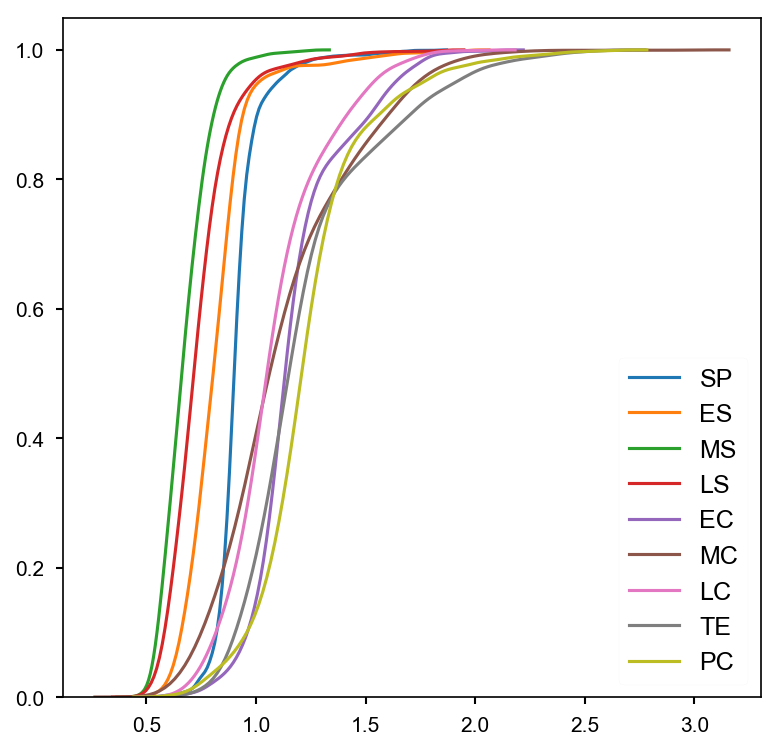

In [20]:
for c, dd in _dat.groupby('cluster'):
    sns.kdeplot(dd.x2a, cumulative=True, label=c)

In [21]:
def stat2(dat):
    obs = dat['obs_ratio']
    lt = 0
    cnt = 0
    for perm in dat.iloc[:, 1:].values.T:
        _, p = mannwhitneyu(obs, perm, alternative='less')
        if p <= 0.01:
            lt += 1
        cnt += 1
    pvalue = 1 - lt / cnt
    return pvalue

def level1(rep):
    # Rep level
    # Decide what genes are expressed and pull out raw counts
    _raw = raw.reindex(columns=clusters.index[clusters.rep == rep])
    genes_on = _raw.sum(axis=1) > (_raw.shape[1] / 3)
    _raw_on = _raw[genes_on]

    # Create a list of Autosomal and X linked genes based on the ones expressed
    # The perumutation test can perumte X/A and then calculate
    _xa = xa.reindex(_raw_on.index)
    _X = _xa.index[_xa == 'X'].tolist()
    _A = _xa.index[_xa == 'A'].tolist()
    
    results = {}
    for cluster, dd in clusters[clusters.rep == rep].groupby('cluster'):
        ratios = []
        _cluster_cells = dd.index
        _raw_on_cluster = _raw_on.reindex(columns=_cluster_cells)
        _X_cluster_scaled = _raw_on_cluster.reindex(_X).sum() / len(_X)
        _A_cluster_scaled = _raw_on_cluster.reindex(_A).sum() / len(_A)
        obs_ratio = _X_cluster_scaled.div(_A_cluster_scaled)
        obs_ratio.name = 'obs_ratio'
        ratios.append(obs_ratio)

        for i in range(1_000):
            pX, pA = permutation_sample(_X, _A)
            pX_cluster_scaled = _raw_on_cluster.reindex(pX).sum() / len(pX)
            pA_cluster_scaled = _raw_on_cluster.reindex(pA).sum() / len(pA)
            permuted_ratio = pX_cluster_scaled.div(pA_cluster_scaled)
            permuted_ratio.name = f'perm{i}'
            ratios.append(permuted_ratio)

        results[cluster] = pd.concat(ratios, axis=1, sort=True)
        
    return results

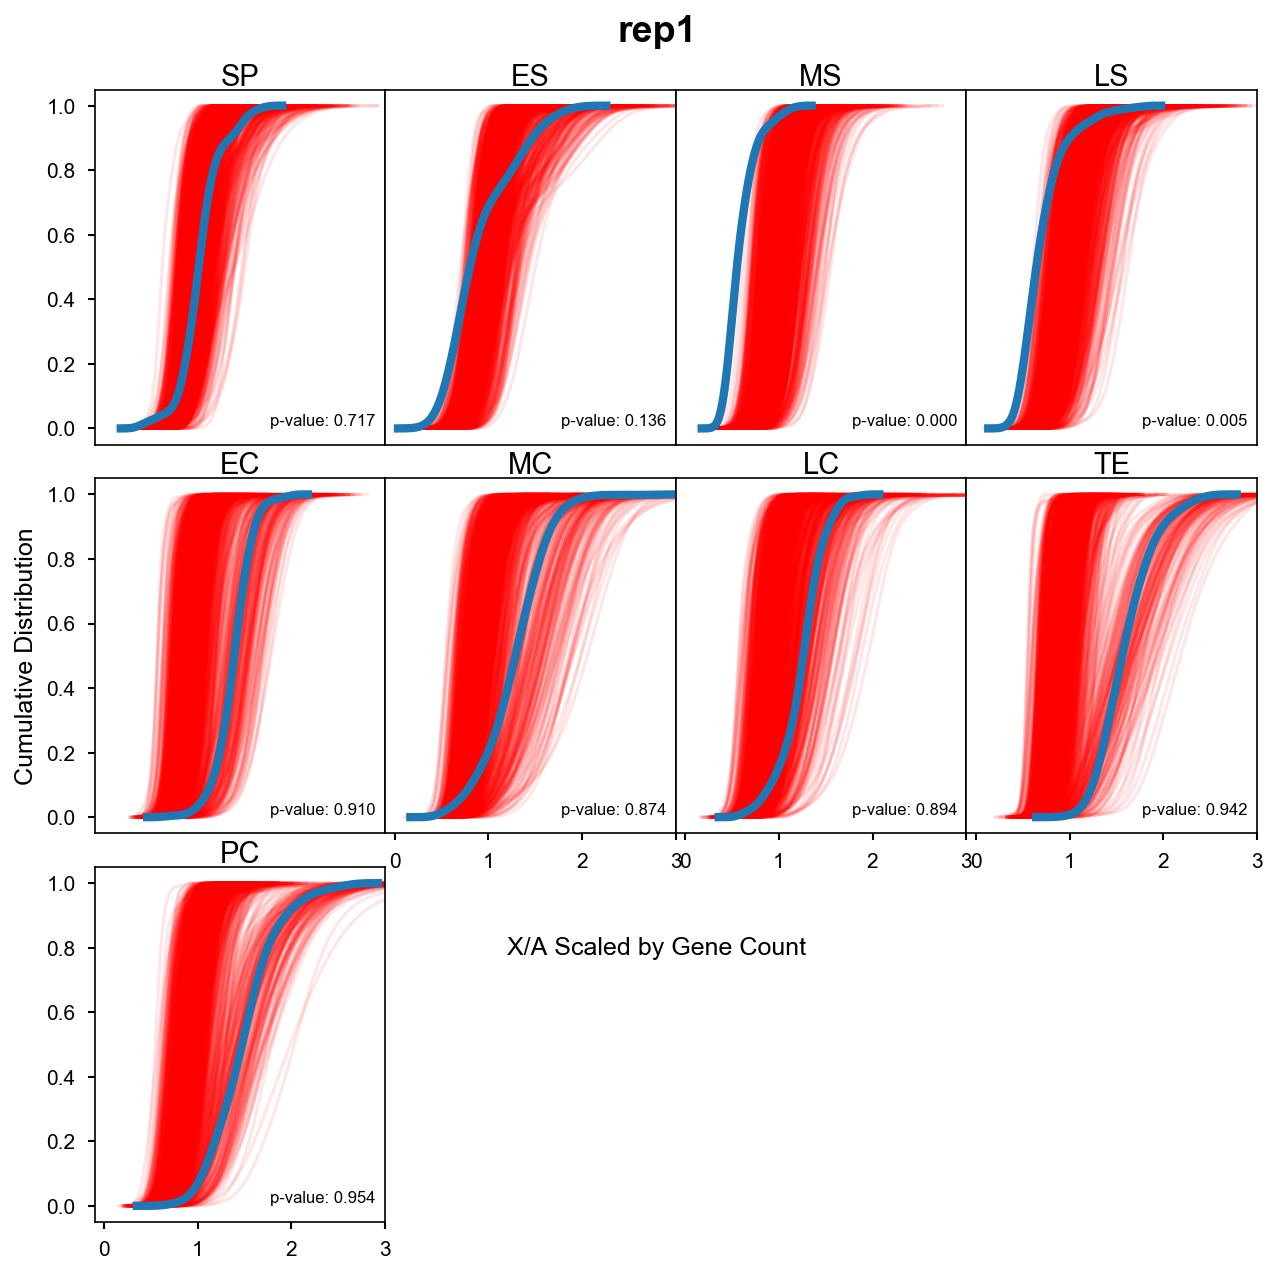

In [22]:
rep = 'rep1'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

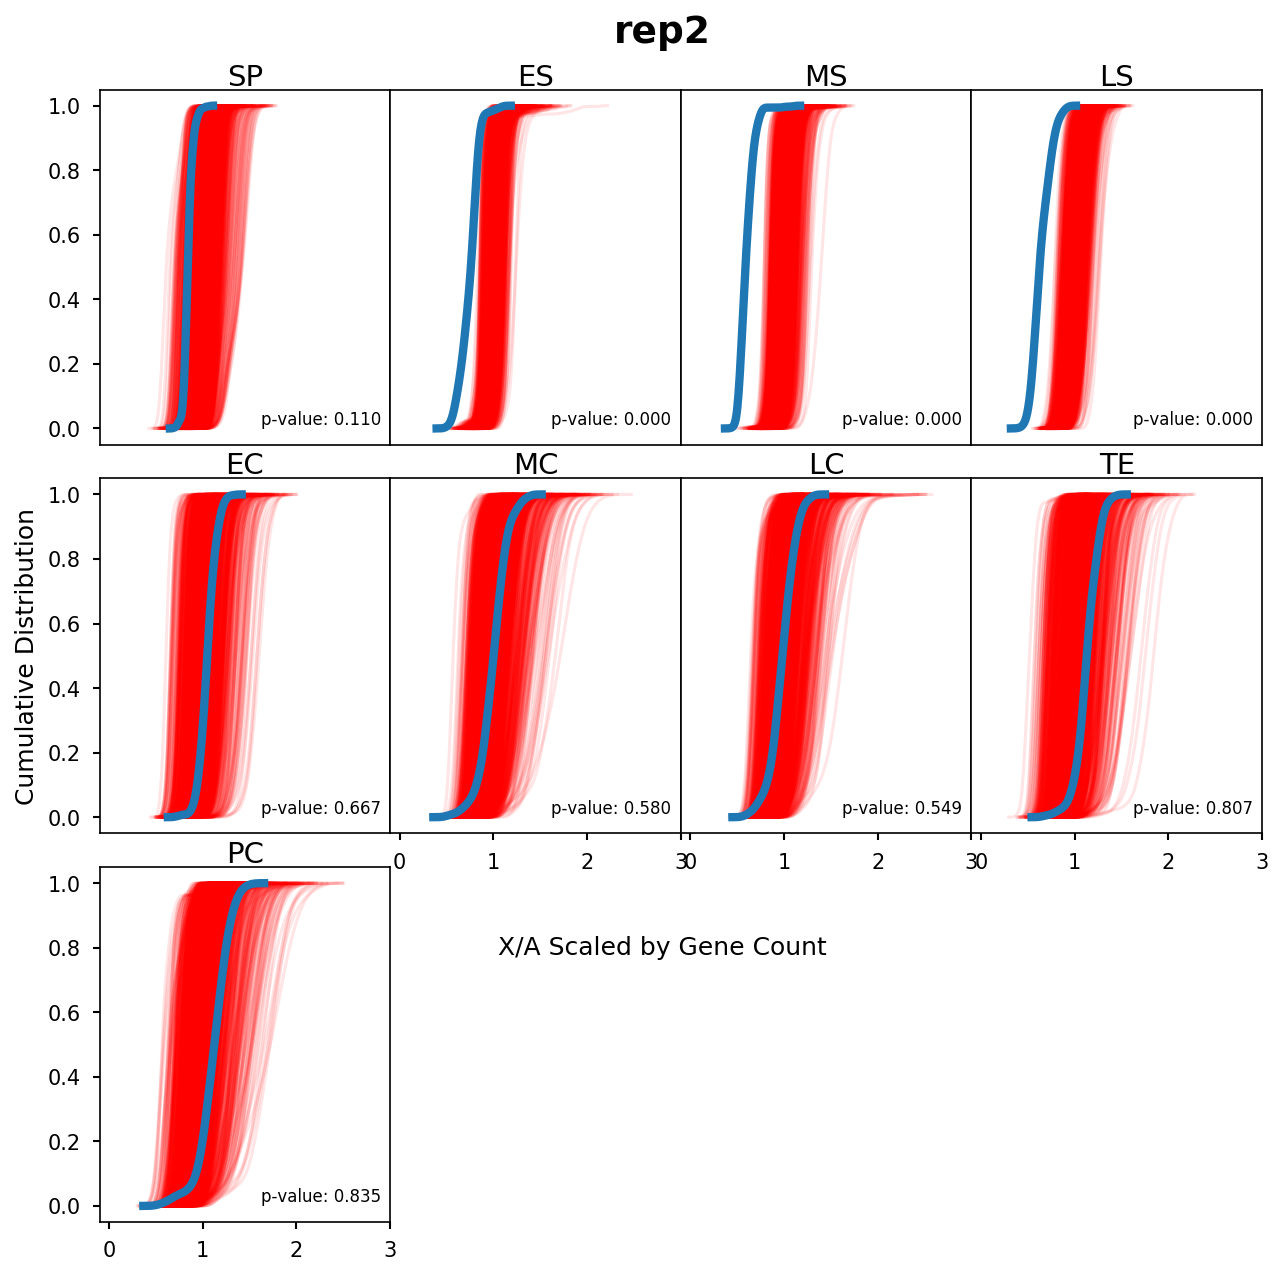

In [408]:
rep = 'rep2'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

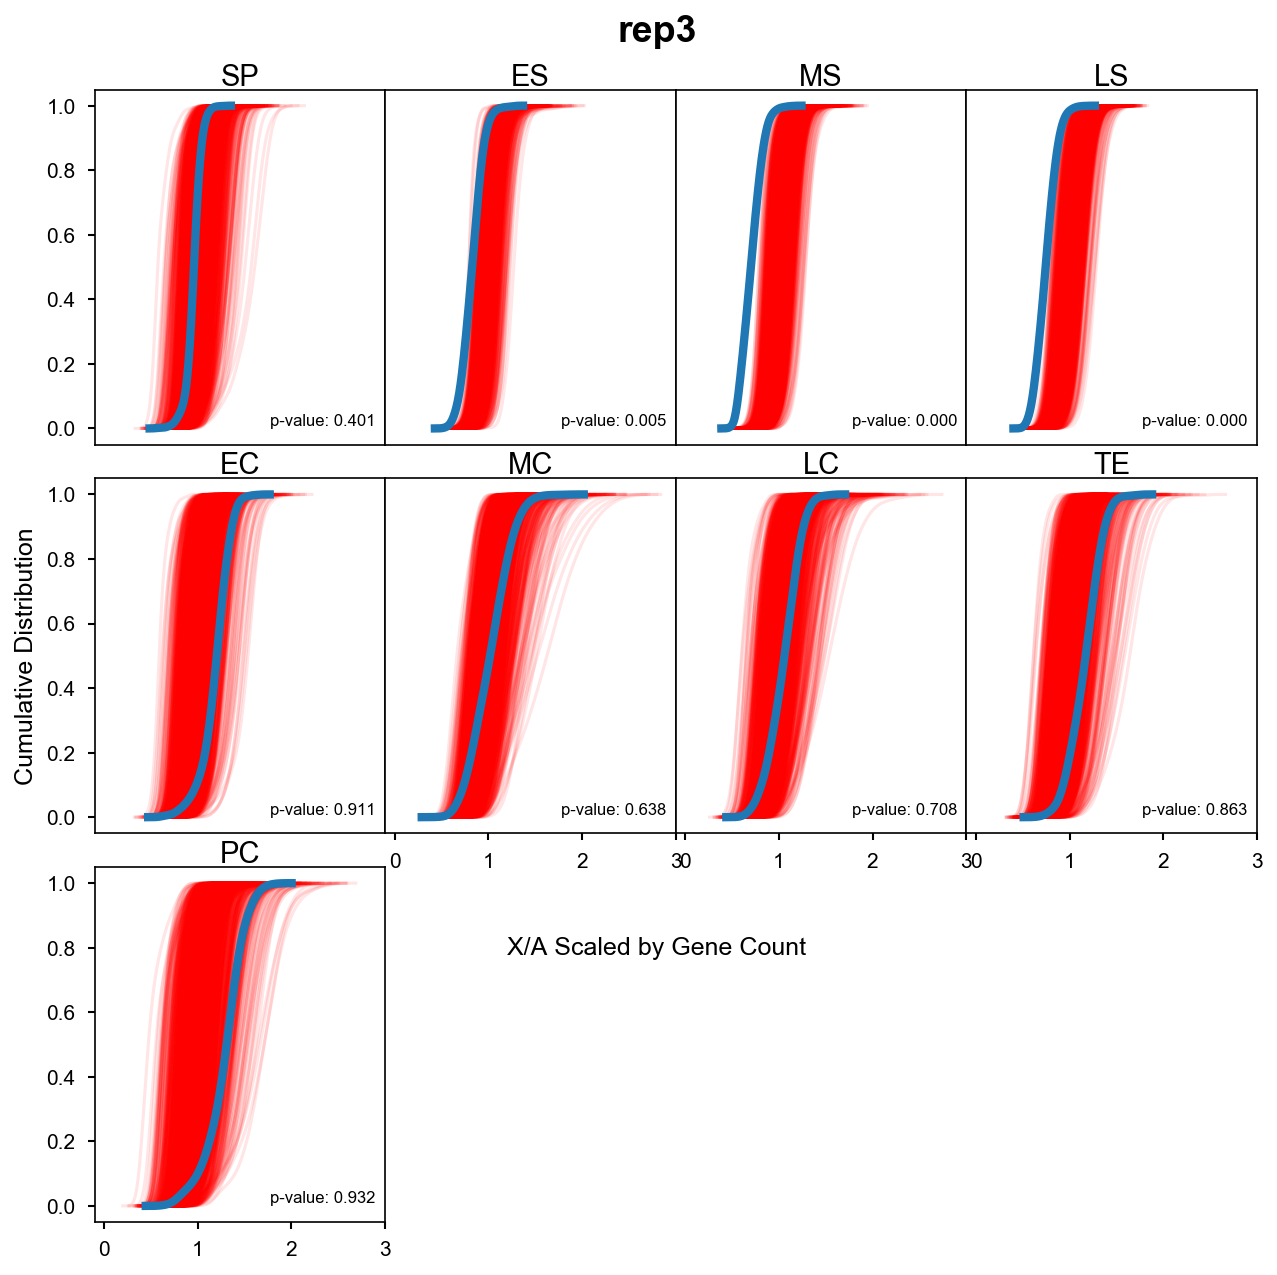

In [23]:
rep = 'rep3'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

# Bulk

In [517]:
def level2(dat):
    # Decide what genes are expressed and pull out raw counts
    genes_on = (dat > 0).sum(axis=1) >= (dat.shape[1] / 3)
    dat_on = dat[genes_on].copy()

    # Create a list of Autosomal and X linked genes based on the ones expressed
    # The perumutation test can perumte X/A and then calculate
    _xa = xa.reindex(dat_on.index)
    _X = _xa.index[_xa == 'X'].tolist()
    _A = _xa.index[_xa == 'A'].tolist()
    
    ratios = []
    dat_on_X = dat_on.reindex(_X)
    dat_on_A = dat_on.reindex(_A)

    scaled_dat_on_X = dat_on_X.sum() / dat_on_X.shape[0]
    scaled_dat_on_A = dat_on_A.sum() / dat_on_A.shape[0]

    obs_ratio = scaled_dat_on_X / scaled_dat_on_A
    obs_ratio.name = 'obs_ratio'

    ratios.append(obs_ratio)

    for i in range(100):
        pX, pA = permutation_sample(_X, _A)
        pX_scaled = dat_on.reindex(pX).sum() / len(pX)
        pA_scaled = dat_on.reindex(pA).sum() / len(pA)
        permuted_ratio = pX_scaled.div(pA_scaled)
        permuted_ratio.name = f'perm{i}'
        ratios.append(permuted_ratio)

    return pd.concat(ratios, axis=1, sort=True)

In [524]:
bulk = pd.read_parquet('../output/bulk-rnaseq-wf/aggregation/gene_level_counts.parquet')
bulk = bulk[~bulk.index.str.startswith('ERCC')].copy()

Text(0.5,1,'C4_TDT')

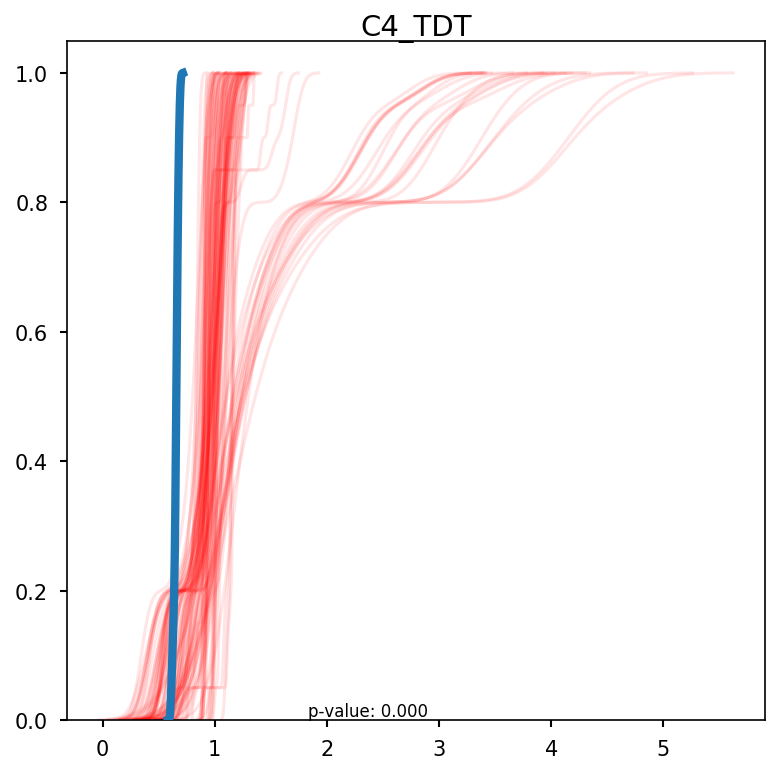

In [525]:
res = level2(bulk)
pvalue = stat2(res)

fig, ax = plt.subplots()
ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
for i, dd in res.iteritems():
    if i == 'obs_ratio':
        sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
    else:
        sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
ax.set_title(k, va='center')

# Add labels and title
#axes[1, 0].set_ylabel('Cumulative Distribution')
#fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
#fig.suptitle(rep, y=.93, fontsize=18);

In [526]:
bulk = pd.read_parquet('/home/fearjm/Projects/larval_gonad_ovary/output/bulk-wf/aggregation/featurecounts.parquet')
bulk = bulk[~bulk.index.str.startswith('ERCC')].copy()

Text(0.5,1,'C4_TDT')

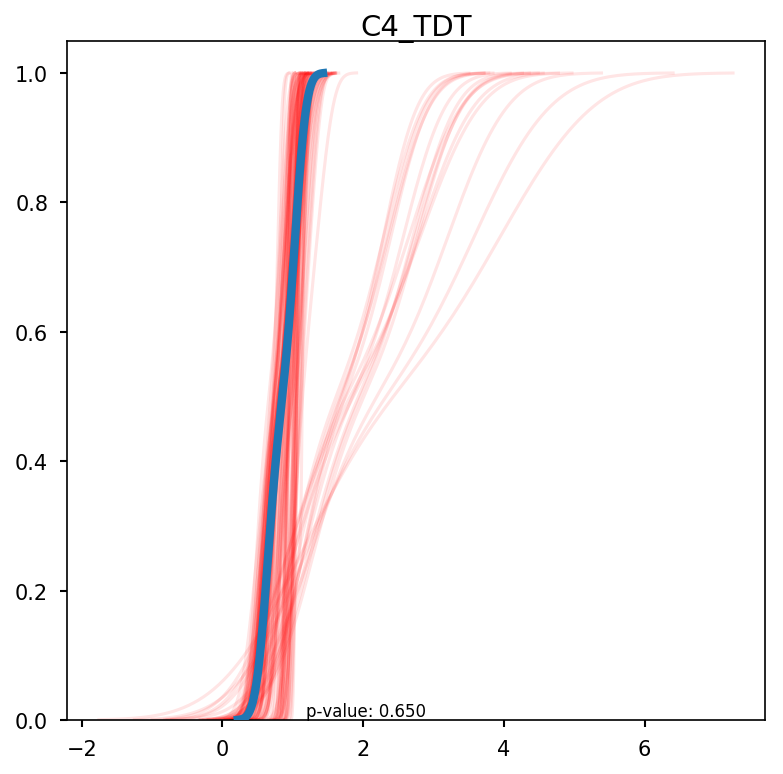

In [527]:
res = level2(bulk)
pvalue = stat2(res)

fig, ax = plt.subplots()
ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
for i, dd in res.iteritems():
    if i == 'obs_ratio':
        sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
    else:
        sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
ax.set_title(k, va='center')

# Add labels and title
#axes[1, 0].set_ylabel('Cumulative Distribution')
#fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
#fig.suptitle(rep, y=.93, fontsize=18);